# Seq2Se2 using pytorch


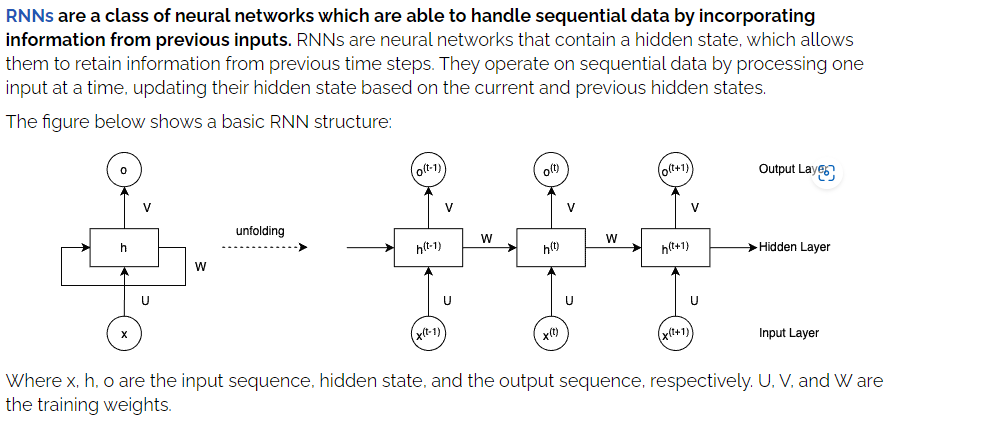

# Understanding the great GRU and Seq2Seq

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch import optim
import re
import itertools
import os 
import codecs
import unicodedata
import csv 
import random
CUDA=torch.cuda.is_available()
device=torch.device("cuda:7" if CUDA else "cpu")

In [214]:
corpus_movie_lines = '/mnt/disk1/Gulshan/rnn/movie_lines.txt'
corpus_movie_conv = '/mnt/disk1/Gulshan/rnn/movie_conversations.txt'
max_len = 25

In [215]:
with open(corpus_movie_lines, 'r', encoding='iso-8859-1') as l:
    lines = l.readlines()
# for line in lines[:8]:
#     print(line.strip())

In [216]:
line_fields=['line_id','character_id','movie_id','character','text']
lines={}
with open(corpus_movie_lines, 'r', encoding='iso-8859-1') as f:
    for line in f:
        values=line.split(' +++$+++ ')
        # values=re.findall(r"[\w']+", line)
        lineobj={}
        for i,field in enumerate(line_fields):
            # print(values)
            lineobj[field]=values[i]
        lines[lineobj['line_id']]=lineobj

In [217]:
lines['L1045']
# 'L1045': {'line_id': 'L1045',
#   'character_id': 'u0',
#   'movie_id': 'm0',
#   'character': 'BIANCA',
#   'text': 'They do not!\n'}

{'line_id': 'L1045',
 'character_id': 'u0',
 'movie_id': 'm0',
 'character': 'BIANCA',
 'text': 'They do not!\n'}

In [218]:
# with open(corpus_movie_conv, 'r', encoding='iso-8859-1') as l:
#     lines = l.readlines()
# # for line in lines[:8]:
# #     print(line.strip())

In [219]:
# x=lines[0]
# print(x)
# re.findall(r"[\w']+", x)

In [220]:
conv_field=['character1id','character2id','movieid','utteranceid']
convservation=[]
with open(corpus_movie_conv, 'r', encoding='iso-8859-1') as l:
    for line in l:
        values=line.split(' +++$+++ ')
        convobj={}
        for i,field in enumerate(conv_field):
            convobj[field]=values[i]
        lineids=eval(convobj['utteranceid'])
        convobj['lines']=[]#creating another key -value pari
        for lineid in lineids:
            convobj['lines'].append(lines[lineid]) # appending the lines dictionary values here for ques -ans
        convservation.append(convobj)
        

In [221]:
# eval("1==5")
# convservation[0]['lines'][0]['text'].strip()


In [222]:
#extract the ques and ans sentecnes
qa_pair=[]
for conv in convservation:
    for i in range(len(conv['lines'])-1):
        input_line=conv['lines'][i]['text'].strip() # strip to remove \n
        target_line=conv['lines'][i+1]['text'].strip()
        #filtering out wrong samples if one is empty
        if input_line and target_line:
            qa_pair.append([input_line,target_line])

In [223]:
qa_pair[1]

["Well, I thought we'd start with pronunciation, if that's okay with you.",
 'Not the hacking and gagging and spitting part.  Please.']

In [224]:
delimiter='\t'
delimiter=str(codecs.decode(delimiter,"unicode_escape"))
# print(delimiter)
with open('qa_movie_line.txt','w',encoding='utf-8') as output:
    writer= csv.writer(output,delimiter=delimiter)
    for pair in qa_pair:
        writer.writerow(pair)

In [225]:
# with open('qa_movie_line.txt','rb') as output:
#     lines=output.readlines()
# for line in lines[:8]:
#     print(line)

In [4]:
PAD_token=0  # for short sentences to match lenth
SOS_token=1
EOS_token=2

class vocabulary:
    def __init__(self,name):
        self.name=name
        self.word2index={}
        self.word2count={}
        self.index2word={PAD_token:"PAD",SOS_token:"SOS",EOS_token:"EOS"}
        self.num_words=3 # pad,sos,eos

    def add_sentence(self,sentence):
        for word in sentence.split(' '):
            self.addword(word)
            
    def addword(self,word):
        if word not in self.word2index:
            self.word2index[word]=self.num_words
            self.word2count[word]=1
            self.index2word[self.num_words]=word
            self.num_words+=1 # intially three
        else:
            self.word2count[word]+=1 
    
    def trim(self,min_count):
        keep_word=[]
        for i,j in self.word2count.items():
            if j>=min_count:
                keep_word.append(i)
        print(f'keep words {len(keep_word)}/{len(self.word2index)} = {(len(keep_word)/len(self.word2index)):.4f}')
        self.word2index={}
        self.word2count={}
        self.index2word={PAD_token:"PAD",SOS_token:"SOS",EOS_token:"EOS"}
        self.num_words=3
        
        for word in keep_word:
            self.addword(word)

In [5]:
def unicode_toascii(s): # turn a unicode to plain ascii
    return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c)!='Mn') #normal form decomposed :NFD,mn:non marking space

In [228]:
# unicodetoascii('Montréal,François')

In [6]:
def normalize_string(s):
    s=unicode_toascii(s.lower().strip())
    # print(s)
    s=re.sub(r"([.!?])",r" \1",s) # replace any ,!? by whitespace
    # print(s)
    s=re.sub(r"([^a-zA-Z.!?]+)",r" ",s) # remove any character that is not a sequenceb of lower o upper case letter ..
    # print(s)
    s=re.sub(r"\s+",r" ",s).strip()
    # print(s)
    
    return s

In [7]:
normalize_string("aa?1.23aa!s's 1   dd?")

'aa ? . aa !s s dd ?'

In [8]:
#reading the files
lines=open('/mnt/disk1/Gulshan/rnn/qa_movie_line.txt','r',encoding='utf-8').read().strip().split('\n')
# print(lines[0])


In [9]:
pairs=[[normalize_string(i) for i in pair.split('\t') ] for pair in lines]


In [10]:
pairs[0]

['can we make this quick ? roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad . again .',
 'well i thought we d start with pronunciation if that s okay with you .']

In [11]:
#intia;lize the vocabu;lary class
voc=vocabulary('corpus_movie_conv')
# voc.

In [12]:
MAX_LEN=10
def filter_pair(p): #return both pairs less than threshold
    return len(p[0].split()) < MAX_LEN and len(p[1].split())< MAX_LEN
def filter_pairs(p):
    return [pair for pair in p if filter_pair(pair)]

In [13]:
# len(pairs[0]) # --> 2
pairs=[pair for pair in pairs if len(pair)>1]
# print(len(pairs)) --> before filter 221282
pairs=filter_pairs(pairs)
# print(len(pairs)) #---> after filter  64271


In [14]:
for pair in pairs:
    voc.add_sentence(pair[0])
    voc.add_sentence(pair[1])
print('counted words :', voc.num_words)

counted words : 18008


In [15]:
# for pair in pairs[:10]:
#     print(pair)

#     break

In [16]:
MIN_COUNT=3
def trim_rarewords(voc,pairs,MIN_COUNT):
    voc.trim(MIN_COUNT) # calling the method trim to remove words freq less than 3
    keep_pairs=[]
    for pair in pairs:
        input_sen=pair[0]
        output_sen=pair[1]
        keep_input=True
        keep_output=True
        
        for word in input_sen.split(): # finding in the voc 
            if word not in voc.word2index:
                keep_input=False 
                break  
        for word in output_sen.split():
            if word not in voc.word2index:
                keep_output=False
                break
        if keep_output and keep_input:
            keep_pairs.append(pair)
    print(f'trimmed from {len(pairs)} to {len(keep_pairs)},total {len(pairs)/len(keep_pairs)}')
    return keep_pairs

In [17]:
trim=trim_rarewords(voc,pairs,MIN_COUNT)

keep words 7823/18005 = 0.4345
trimmed from 64271 to 53165,total 1.2088968306216497


In [18]:
def index_from_sentence(voc,sentence):
    return [voc.word2index[word] for word in sentence.split(' ')]+[EOS_token]

In [19]:
# print(pairs[1][0])
index_from_sentence(voc,pairs[1][0])


[7, 8, 9, 10, 4, 11, 12, 13, 2]

In [20]:
# #for understanding purpose
# q_sen=[]
# a_sen=[]
# for pair in pairs[:2]: # pairs[:2] -> first 5 qa 
#     q_sen.append(pair[0])
#     a_sen.append(pair[1])
# # print(len(q_sen),len(a_sen))
# index=[indexfromsentence(voc,sen) for sen in q_sen]
# leng=[len(ind) for ind in index ]
# max(leng)    

In [21]:
# #understanding zip and zip longest
# a=['1','2','3']
# b=['a','b','c','d','e']
# print(list(zip(a,b)))
# print(list(itertools.zip_longest(a,b)))

In [22]:
# #for understaing zip.longest
# a=[[3, 4, 2], [7, 8, 9, 10, 4, 11, 12, 13, 2]]
# print(list(itertools.zip_longest(*a)))
# list(itertools.zip_longest((*a),fillvalue=0))

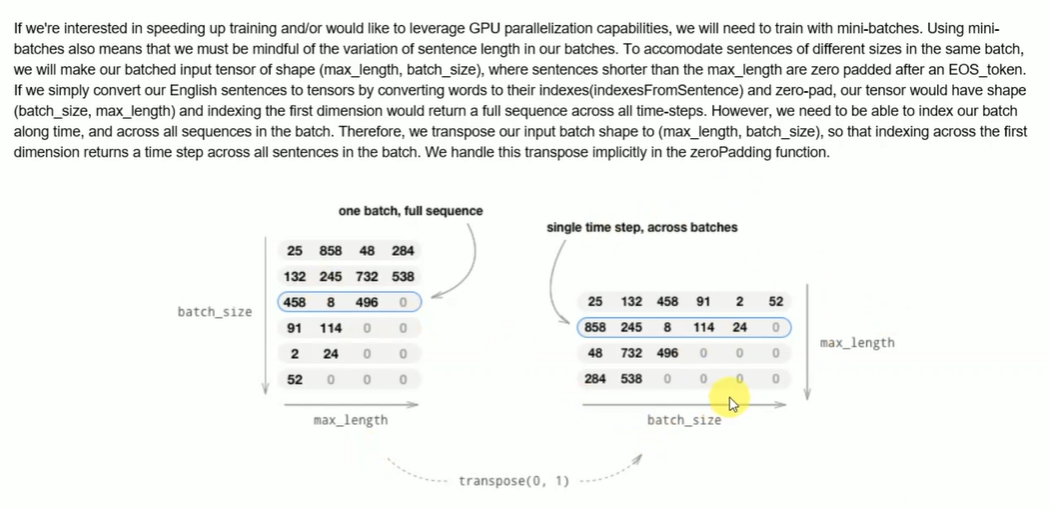

In [23]:
def zero_padding(a,fillvalue=0):
    return list(itertools.zip_longest((*a),fillvalue=0))
# a=[[3, 4, 2], [7, 8, 9, 10, 4, 11, 12, 13, 2]]
# x=zero_padding(zero_padding(a))
# x

In [24]:
def binary_matrix(a,value=0):
    m=[]
    for i,seq in enumerate(a):
        m.append([])
        # print(m)
        for token in seq:
            if token == PAD_token: # PADtoken is 0 so it is 0 for padtoken and 1 for other values
                m[i].append(0) 
            else:
                m[i].append(1)
    return m
# binary_matrix(x)

In [25]:
# to return padded input sequence tensor 
# and as well as a tensor of lengths for each of the sequence in the batch
def input_var(l,voc):
    index_batch=[index_from_sentence(voc,sen) for sen in l]
    length=torch.tensor([len(ind) for ind in index_batch])
    pad_list=zero_padding(index_batch)
    pad_var=torch.LongTensor(pad_list)
    return pad_var,length
    
    

In [26]:
def out_var(l,voc):
    index_batch=[index_from_sentence(voc,sen) for sen in l]
    max_target_len= max([len(ind) for ind in index_batch])
    pad_list=zero_padding(index_batch)
    pad_var=torch.LongTensor(pad_list)
    mask=binary_matrix(pad_list)
    mask=torch.ByteTensor(mask)
    return pad_var,mask,max_target_len

In [27]:
# # lamda example
# def mul(x):
#     return x*2
# print(mul(2))
# x= lambda x:x*2
# x(2)

In [28]:
def dataloader(voc,pair_batch):
    pair_batch.sort(key=lambda x:len(x[0].split(" ")),reverse=True) #sorting in desc order
    in_batch,out_batch=[],[]
    for pair in pair_batch:
        in_batch.append(pair[0])
        out_batch.append(pair[1])
    inp_var,length=input_var(in_batch,voc)
    output,mask,max_target_len=out_var(out_batch,voc)
    return inp_var,length,output,mask,max_target_len
    

In [29]:
bs=5
inp_var,length, output,mask,max_target_len=dataloader(voc,[random.choice(trim) for _ in range(bs)])
print("inp",inp_var)
print(inp_var.shape)
print(length) 
print("output",output)
print("output",output.shape)
print(mask)
print(max_target_len)

inp tensor([[ 197,  318, 1493,   77, 1292],
        [ 117,  572,   47,  115,   56],
        [   7,    4,   65,   76,  227],
        [   8,  266,   24,    6,    4],
        [ 208,   35,    7,    2,    2],
        [2079,   76,    6,    0,    0],
        [ 188,  102,    2,    0,    0],
        [  38,    4,    0,    0,    0],
        [   6,    2,    0,    0,    0],
        [   2,    0,    0,    0,    0]])
torch.Size([10, 5])
tensor([10,  9,  7,  5,  5])
output tensor([[  34,   12,   56,   50,   50],
        [2080,  519,  827,   47,   92],
        [  25,  329,   67,   27,  463],
        [ 197,  164,    4,   47,    6],
        [ 117,    6,    2,    6,    2],
        [   4,    2,    0,    2,    0],
        [   2,    0,    0,    0,    0]])
output torch.Size([7, 5])
tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 0, 1, 0],
        [1, 0, 0, 0, 0]], dtype=torch.uint8)
7


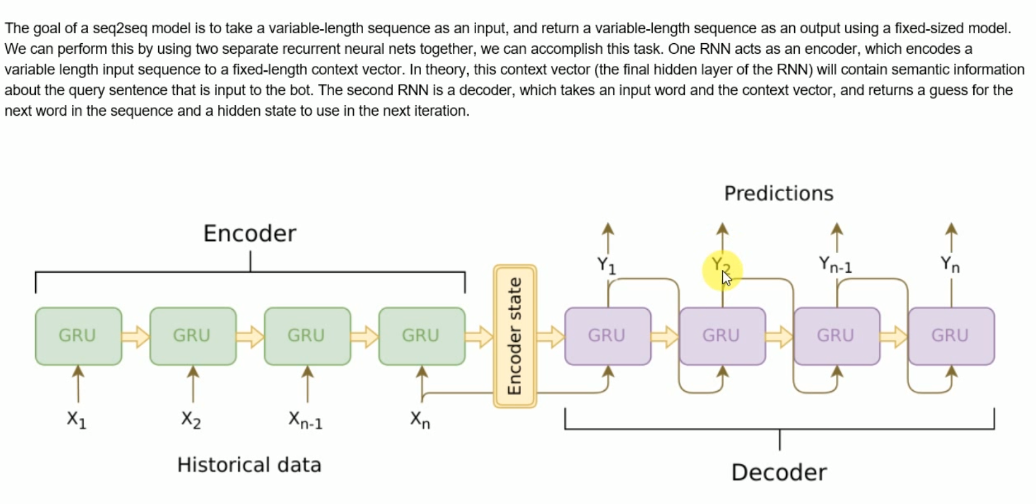

# ENCODER

In [30]:
class encoder_rnn(nn.Module):
    def __init__(self,hidden_size,embed_size,n_layer=1,dropout=0):
        super(encoder_rnn,self).__init__()
        self.embed=embed_size
        self.hidden_size=hidden_size
        self.n_layer=n_layer
        #in gru-> torch.nn.GRU(self, input_size, hidden_size, num_layers=1, 
        # bias=True, batch_first=False, dropout=0.0, 
        # bidirectional=False, device=None, dtype=None)
        # above input size are embed size . and it is set to hiiden size because both size are same
        self.gru=nn.GRU(hidden_size,hidden_size,n_layer,dropout=(0 if n_layer == 1 else dropout),bidirectional=True)
    
    def forward(self,input_seq,input_length,hidden=None):
        #input_seq -> batch of first input sen ; shape (maxlength,batch_size)
        #input_length -> list of sen lenght coressponding to each sen in the batch
        #hidden -> ( n_layers * num_directions, batch_size,hidden_size) -> num_direc.. is 2 cause of bidirectional rnn
        #convert word indexs into embeddinbgs
        # input_seq -> torch.Size([8, 5])
        # input_length -> torch.Size([5]) && tensor([8, 7, 5, 4, 4])
        embedded=self.embed(input_seq)
        # embeded -> torch.Size([8, 5, 500])
        #pack padded for rnn module
        packed=torch.nn.utils.rnn.pack_padded_sequence(embedded,input_length)
        #forward pass thrugh gru
        outputs,hidden=self.gru(packed,hidden)
        #unpacking
        # hidden.shape -> torch.Size([4, 5, 500])
        outputs,_= torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # output shape -> torch.Size([8, 5, 1000])
        #sum bidirectional gru units
        outputs = outputs[:,:,:self.hidden_size]+outputs[:,:,self.hidden_size:]
        # output shape -> torch.Size([8, 5, 500])
        
        return outputs,hidden
    

# pack padded
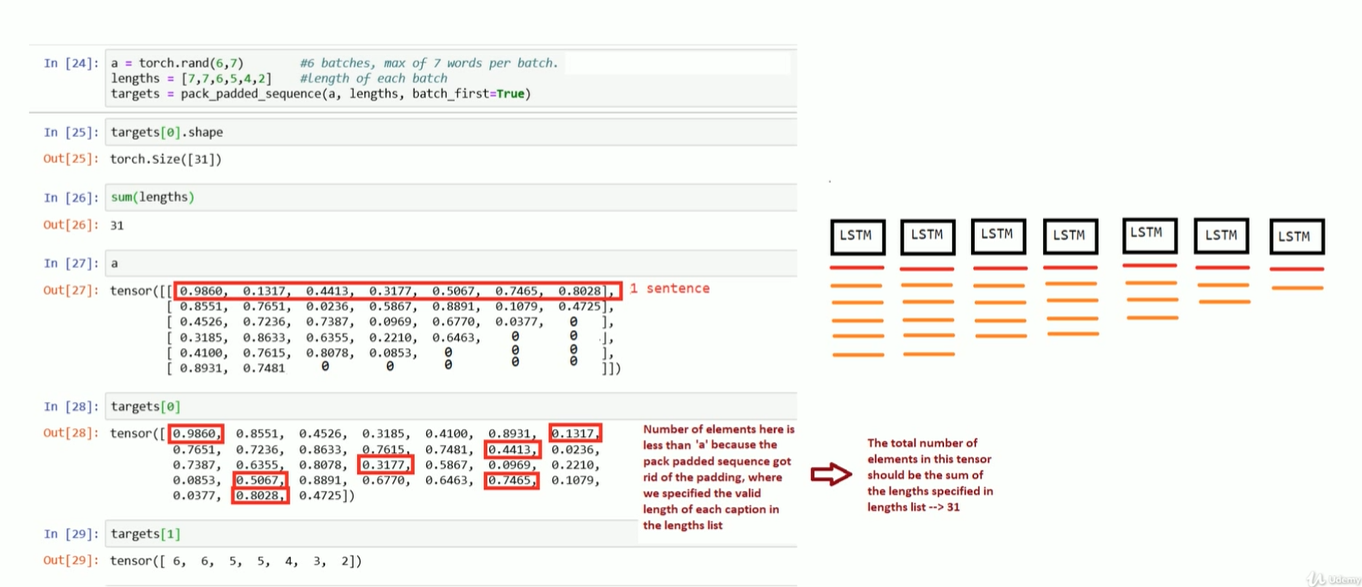

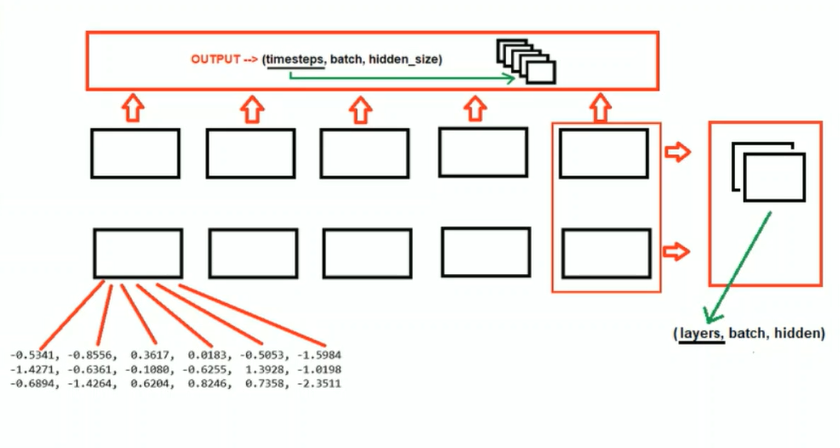

rnn=nn.GRU(6,20,2)# (inputsize,hiddensize,numlayer)
input=torch.randn(5,3,6) # (seq,batch,input)
h0=torch.randn(2,3,20)  #(num_layer,batch,hidden)
out,hd=rnn(input,h0)    
print(out.shape)    # (Seq,batch,hidden)
print(h0.shape)  

------
torch.Size([5, 3, 20])
torch.Size([2, 3, 20])


In [31]:
# rnn=nn.GRU(6,20,2)# (inputsize,hiddensize,numlayer)
# input_=torch.randn(5,3,6) # (seq,batch,input)
# print(input_.shape)
# h0=torch.randn(2,3,20)  #(num_layer,batch,hidden)
# out,hd=rnn(input_,h0)    
# print(out.shape)    # (Seq,batch,hidden)
# print(h0.shape)

In [32]:
# e=encoderrnn(hidden_size=5,embed_size=5,n_layer=2,dropout=0.1)
# i1=torch.randn(2,5)
# i2=torch.randn(10)
# h=torch.randn(2,5,5)
# e(i1,i2,h)

In [33]:
import torch.nn.functional as F
class attention(nn.Module):
    def __init__(self,method,hidden_size): # method -> mul or add operation 
        super(attention,self).__init__()
        self.method=method
        self.hidden_size=hidden_size
        
    def dot_score(self,hidden,encoder_output):
        return torch.sum(hidden * encoder_output,dim=2)
    
    def forward(self,hidden,encoder_outputs):
        #hidden shape : (1,batch,hiddensize)
        #encoder output : (max_length,bacth,hidden)
        # hidden * encoder =((1,batch,hiddensize) * (max_length,bacth,hidden) = (max_len,batch,hidden)
        # print(hidden.shape) # -> torch.Size([1, 5, 500])
        # print(encoder_outputs.shape) # -> torch.Size([9, 5, 500])
        atten=self.dot_score(hidden,encoder_outputs) # SHAPE : (max_len,batch)
        # print(atten.shape) # -> torch.Size([9, 5])
        atten=atten.t() # transpose -> (batch ,max len)
        # print(atten.shape) # -> torch.Size([5,9])
        # print(F.softmax(atten,dim=1).unsqueeze(1).shape) #->torch.Size([5, 1, 9])
        return F.softmax(atten,dim=1).unsqueeze(1) # return softmax with added dim unsequueze
    

In [34]:
# a=torch.randn(1,3,7)
# b=torch.randn(2,3,7)
# print(a)
# print(b)
# print(torch.sum(a*b,dim=2))
# c=a*b
# print('\n')
# print(c.shape)
# print(c)
# print(torch.sum(c,dim=2))
# d=torch.sum(c,dim=2)

In [35]:
# print(d.shape)
# print(d)
# F.softmax(d,dim=1)

# Decoder and Attention
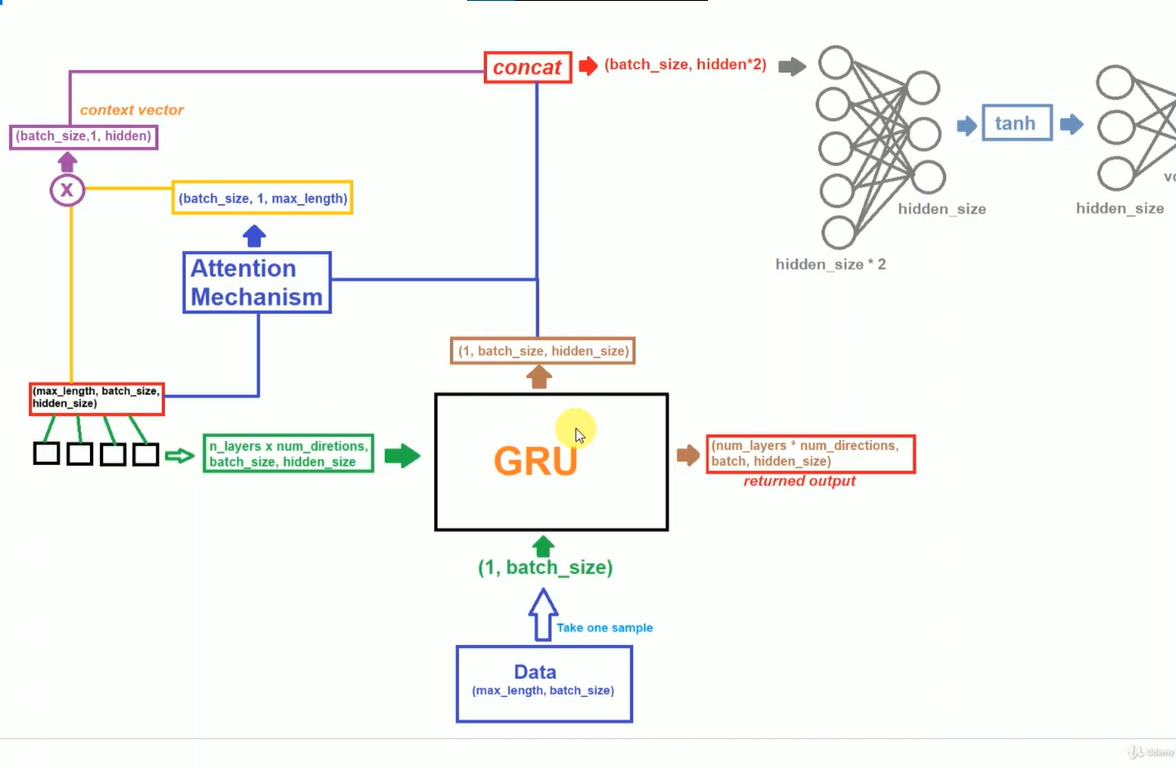

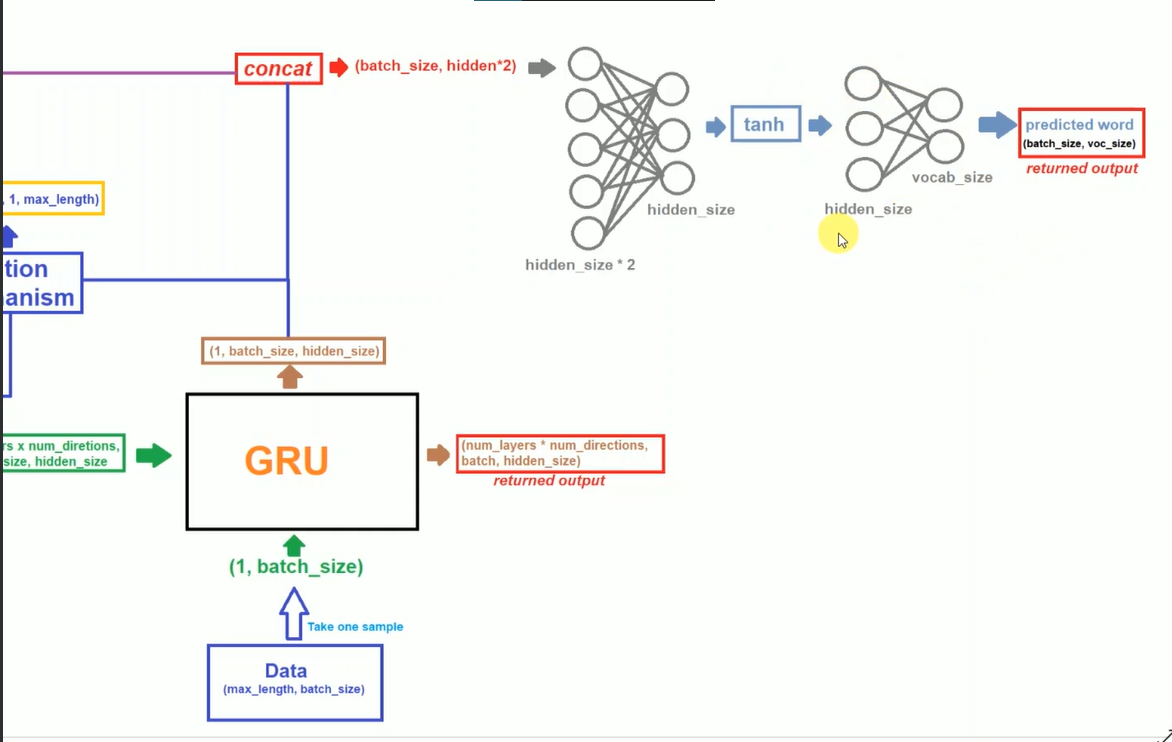

# Decoder

In [36]:
class decoder_rnn(nn.Module):
    def __init__(self,attn_model,embed_size,hidd_size,out_size,n_layer=1,dropout=0.1):
        super(decoder_rnn,self).__init__()
        self.embed_size=embed_size
        self.hidd_size=hidd_size
        self.out_size=out_size
        self.n_layer=n_layer
        self.drop=dropout
        self.attn_model=attn_model
        
        self.gru=nn.GRU(hidd_size,hidd_size,n_layer,dropout=(0 if n_layer==1 else dropout))
        self.embed_dropout=nn.Dropout(dropout)
        self.concat=nn.Linear(hidd_size*2,hidd_size)
        self.out=nn.Linear(hidd_size,out_size)
        
    def forward(self,decoder_in,last_hidd,encod_out):
        #input : one time step (one word) (1, batch size)
        #last hidd : final hidden state of encoder gru 
        # encod_out : encoder models output
        # we run this 1 step (bacth of word) at a time
        # print(input.shape) #-> torch.Size([1, 5])
        # print(last_hidd.shape) #-> torch.Size([2, 5, 500])
        embed=self.embed_size(decoder_in)
        # print(embed.shape) #-> torch.Size([1, 5, 500])
        embed=self.embed_dropout(embed)
        # print(embed.shape) #-> torch.Size([1, 5, 500])
        
        rnn_out,hidd=self.gru(embed,last_hidd)
        #rnn out (1,bacthsize,num_dir*hidden size)
        # hidden shape (num_lay*num_dir,batch,hiddensize)
        # print(rnn_out.shape) # -> torch.Size([1, 5, 500])
        # print(hidd.shape)    # -> torch.Size([2, 5, 500])
        att_weight=self.attn_model(rnn_out,encod_out)
        # print(att_weight.shape) # -> torch.Size([5, 1, 9])
        
        #multiply attn weight to encoder output to get new weighted ->sum context vector
        # (batch size,1,max_len) bmm (batch multiply) with (batch size,max len,hidden) = (batchsize,1,hidden)
        # print(encod_out.shape)  # -> torch.Size([9,5,500])
        # print(encod_out.transpose(0,1).shape) # ->torch.Size([5, 9, 500])
        
        context=att_weight.bmm(encod_out.transpose(0,1))
        
        # print(context.shape) # ->torch.Size([5, 1, 500])
        
        # rnn out (q,batch ,hidden) to squeeze to remove dim 0
        rnn_out= rnn_out.squeeze(0)
        # print(rnn_out.shape) # -> torch.Size([5, 500])
        # same as we did for rnn out to concat
        context=context.squeeze(1)
        # print(context.shape) # ->torch.Size([5,500])
        
        concat_input=torch.cat((rnn_out,context),1)
        # print(concat_input.shape) # -> torch.Size([5, 1000])
        #concat is another form of represrtation 
        concat_out=torch.tanh(self.concat(concat_input))
        # print(concat_out.shape) #-> torch.Size([5, 500])
        out=self.out(concat_out)
        # print(out.shape) # -> torch.Size([5, 7826])
        out=F.softmax(out,dim=1)
        # print(out.shape) # -> torch.Size([5, 7826])
        
        return out,hidd

# loss functions

In [37]:
def loss_fn(decoder_out,target,mask):# we are using negative log likihood loss
    n_total=mask.sum() # how many element to consider
    # mask eg: [1,1,1,0] -> here how many words are present 1 is word 0 not a word
    # print(decoder_out.shape) # -> torch.Size([5, 7826])
    # print(target.shape)      # -> torch.Size([5]) && tensor([167,  62,  48, 266,  12])
    # print(mask.shape)         # -> torch.Size([5]) && tensor([1, 1, 1, 1, 1]
    target=target.view(-1,1)
    # print(target.shape)       # -> torch.Size([5, 1])
    #decoder shape (batch,vocabsize),target size =(batchsize,1)
    
    gathered_tensor=torch.gather(decoder_out,1,target) # input , dim , index
    # print(gathered_tensor.shape)    # -> torch.Size([5, 1])
    #calcaultae loss
    cross_entropy= -torch.log(gathered_tensor)
    loss= cross_entropy.masked_select(mask)
    # print(mask)
    #calculate mean loss
    loss=loss.mean()
    loss=loss.to(device)
    return loss,n_total


In [38]:
bs=5
batch=dataloader(voc,[random.choice(trim) for _ in range(bs)])
input_,input_length,target_variable,mask,mask_target_len=batch
print("input :",input_)
# print(voc.word2index)
print("input shape:",input_.shape)
print("\n")
# demonstration of words in the arrary in the input
for i in range(input_.shape[0]):
    for j in input_[i]:
        # print(j,)
        print(f'{voc.index2word[j.item()]}',end=' ')

    print("\n",end='')
print("\n")
print("input_length :",input_length)
print("target_variable : ",target_variable)
print("target shape : ",target_variable.shape)
print("mask : ",mask)
print("mask_target_len : ",mask_target_len)


input : tensor([[  25,  167,   53,  100,  112],
        [ 359,    6, 5141,   92,   18],
        [ 101,    7, 4105,    7,   36],
        [ 148,  122,    4, 6804,    6],
        [1528,   77,    4,    6,    2],
        [  21,  326,    4,    2,    0],
        [ 360,    6,    6,    0,    0],
        [  99,    2,    2,    0,    0],
        [   4,    0,    0,    0,    0],
        [   2,    0,    0,    0,    0]])
input shape: torch.Size([10, 5])


i yeah the why just 
see ? monthly are like 
he you interview you that 
d and . yelling ? 
walk who . ? EOS 
out else . EOS PAD 
next ? ? PAD PAD 
month EOS EOS PAD PAD 
. PAD PAD PAD PAD 
EOS PAD PAD PAD PAD 


input_length : tensor([10,  8,  8,  6,  5])
target_variable :  tensor([[  36,  548,  124,   68,   18],
        [  37, 1141,   66,   25, 4929],
        [ 266,    4,   98, 1172,  203],
        [   4,    2,   53,  319,   12],
        [   2,    0, 5489,    6, 1717],
        [   0,    0,    4,    2,    4],
        [   0,    0,    4,    0,    2],
 

In [39]:
# FOR TORCH GATHER
# x=torch.randn(6,7)
# print("input :",x)
# mas=mask[0]
# # mas=torch.ones(6,dtype=bool)

# print("mask : ",mas)
# print("mask : ",mas.shape)
# m=torch.randn(6,1).long()
# print("target : ",m)
# print("target : ",m.shape)
# gathered_tensor=torch.gather(x,1,m)
# print("gatheredd ten.. :",gathered_tensor)
# cross_entropy= -torch.log(gathered_tensor)
# print("cross entropy : ",cross_entropy)
# loss= cross_entropy.masked_select(mas)
# print("loss: ",loss)
# print("loss shape : ",loss.shape)
#output
# input : tensor([[ 0.6656, -0.8372, -0.8935, -1.8969,  0.6748, -0.3201, -1.5511,  2.2112],
#         [-0.4771,  0.0337, -0.2570, -1.0448,  0.8479, -0.5887, -0.2824, -1.1314],
#         [-0.0772,  0.4899,  1.4405,  1.3435, -1.1151, -0.1911, -0.8222, -0.1759],
#         [-0.2923,  0.3677,  0.9401, -2.3273, -0.8926,  0.9961, -0.9302, -1.6024],
#         [-0.4321, -0.1325,  0.9769,  1.3432,  1.0895,  0.9533, -1.2039, -0.3223]])
# mask :  tensor([1, 1, 1, 1, 1], dtype=torch.uint8)
# mask :  torch.Size([5])
# target :  tensor([[0],
#         [0],
#         [1],
#         [0],
#         [0]])
# target :  torch.Size([5, 1])
# gatheredd ten.. : tensor([[ 0.6656],
#         [-0.4771],
#         [ 0.4899],
#         [-0.2923],
#         [-0.4321]])
# cross entropy :  tensor([[0.4071],
#         [   nan],
#         [0.7136],
#         [   nan],
#         [   nan]])
# loss:  tensor([0.4071, 0.4071, 0.4071, 0.4071, 0.4071,    nan,    nan,    nan,    nan,
#            nan, 0.7136, 0.7136, 0.7136, 0.7136, 0.7136,    nan,    nan,    nan,
#            nan,    nan,    nan,    nan,    nan,    nan,    nan])
# loss shape :  torch.Size([25])


In [40]:
# loss demo
# x=torch.randn(5,7826)
# loss_fn(x,target_variable[0],mask[0])

In [41]:
# define parameters
hidden_size=500
encoder_layer=2
decoder_layer=2
dropout=0.1
# attn_model='dot'
attn_model=attention('dot',hidden_size=500)
embedding=nn.Embedding(voc.num_words,hidden_size)
#define encdoer and decoder
# (self,hidden_size,embed_size,n_layer=1,dropout=0)
encoder=encoder_rnn(hidden_size,embedding,encoder_layer,dropout).to(device)
#(self,attn_model,embed_size,hidd_size,out_size,n_layer=1,dropout=0.1)
decoder=decoder_rnn(attn_model,embedding,hidden_size,voc.num_words,decoder_layer,dropout).to(device)
# to make droput in train mode
encoder.train()
decoder.train()
# optimizer
encoder_optim=optim.Adam(encoder.parameters(),lr=0.0001)
decoder_optim=optim.Adam(decoder.parameters(),lr=0.0001)

encoder_optim.zero_grad()
decoder_optim.zero_grad()
input_=input_.to(device)
# input_length=input_length.to(device)
target_variable=target_variable.to(device)
mask=mask.to(device)

In [42]:
# This code snippet is part of a sequence-to-sequence model implementation using PyTorch for natural language processing tasks like machine translation. Here's a breakdown of what each part of the code is doing:
encoder_out,encoder_hidden=encoder(input_,input_length)
print("encoder_out :",encoder_out.shape)
print("encoder_hidden : ",encoder_hidden.shape)
decoder_input=torch.LongTensor([[SOS_token for _ in range(bs)]]).to(device)
# decoder_input -> tensor([[1, 1, 1, 1, 1]])
# passing encoder last hidden to decoder hidden state (decoder.n_layer -> 2)
decoder_hidden=encoder_hidden[:decoder.n_layer]
# print(encoder_hidden[:,:,:2])
# encoder_hidden[:2].shape -> torch.Size([2, 5, 500])

# decoder_hidden
#decoder_hidden.shape -> torch.Size([2, 5, 500])

encoder_out : torch.Size([10, 5, 500])
encoder_hidden :  torch.Size([4, 5, 500])


In [43]:
attn_model=attention('dot',hidden_size=500)
decoder=decoder_rnn(attn_model,embedding,hidden_size,voc.num_words,decoder_layer,dropout).to(device)
decoder_output,decoder_hidden= decoder(decoder_input,decoder_hidden,encoder_out)

In [44]:
# losses=0
# print_loss=[]
# n_totals=0
# for t in range(max_target_len):
#     decoder_output,decoder_hidden= decoder(decoder_input,decoder_hidden,encoder_out)
#     print("decoder_output :",decoder_output.shape)
#     print("decoder_hidden :",decoder_hidden.shape)
#     # teacher forcing : next input is target
#     print("target_variable :",target_variable[t])
#     print("target_variable : ",target_variable[t].shape)
#     decoder_input= target_variable[t].view(1,-1)
#     print("target_variable at the current time step before reshaping :",target_variable[t])
#     print("target_variable at the current time step after reshaping :",target_variable[t].shape)
#     print("decoder input shape (reshape the target varaiable) :",decoder_input.shape)
#     #calculate and accumulate loss
#     print("mask at current timestep",mask[t])
#     print("mask at current timestep shape",mask[t].shape)
#     mask_loss,ntotal=loss_fn(decoder_output,target_variable[t],mask[t])
#     print("mask_loss : ",mask_loss)
#     print("total : ",ntotal)
#     losses+=mask_loss
#     print('losses :', losses)
#     print_loss.append(mask_loss.item()*ntotal) # mask_loss returens one loss so we mul by how many words ie ntotal
#     print("print_loss : ",print_loss)
#     n_totals+=ntotal
#     print("n_totals : ",n_totals)
#     encoder_optim.step()
#     decoder_optim.step()
#     returned_loss=sum(print_loss)/n_totals

#     print("returned_loss : ",returned_loss)
#     print("\n")
#     print("----------------ONE TIMESTEP COMPELTED------------")
#     print("\n")


# TRAINING

In [45]:
MAX_LENGTH = 10
# teacher_forcing_ratio=0.5
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip,teacher_forcing_ratio, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for RNN packing should always be on the CPU
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layer]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = loss_fn(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = loss_fn(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropagation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [46]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, 
               decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, loadFilename,teacher_forcing_ratio):
    
    # Load batches for each iteration
    training_batches = [dataloader(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    # if loadFilename:
    #     start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip,teacher_forcing_ratio)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

In [47]:
# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#``attn_model = 'general'``
#``attn_model = 'concat'``
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64
save_dir='/mnt/disk1/Gulshan/rnn'
# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 1000

loadFilename = os.path.join('/mnt/disk1/Gulshan/rnn', model_name,
                    '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
                    '{}_checkpoint.tar'.format(checkpoint_iter))

In [48]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 3.0
n_iteration = 100
print_every = 1
save_every = 500
# Ensure dropout layers are in train mode
encoder.train()
decoder.train()
# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
# if loadFilename:
#     encoder_optimizer.load_state_dict(encoder_optimizer_sd)
#     decoder_optimizer.load_state_dict(decoder_optimizer_sd)
# If you have CUDA, configure CUDA to call
# for state in encoder_optimizer.state.values():
#     for k, v in state.items():
#         if isinstance(v, torch.Tensor):
#             state[k] = v.cuda()

# for state in decoder_optimizer.state.values():
#     for k, v in state.items():
#         if isinstance(v, torch.Tensor):
#             state[k] = v.cuda()

# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, trim, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, loadFilename,teacher_forcing_ratio)

Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 1; Percent complete: 1.0%; Average loss: 8.9732


/tmp/ipykernel_2720816/1165674746.py:15: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss= cross_entropy.masked_select(mask)
/home/antpc/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/cuda/IndexKernel.cpp:73.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iteration: 2; Percent complete: 2.0%; Average loss: 8.8313
Iteration: 3; Percent complete: 3.0%; Average loss: 8.7134
Iteration: 4; Percent complete: 4.0%; Average loss: 8.4336
Iteration: 5; Percent complete: 5.0%; Average loss: 8.2557
Iteration: 6; Percent complete: 6.0%; Average loss: 7.9087
Iteration: 7; Percent complete: 7.0%; Average loss: 7.5625
Iteration: 8; Percent complete: 8.0%; Average loss: 6.9681
Iteration: 9; Percent complete: 9.0%; Average loss: 6.8605
Iteration: 10; Percent complete: 10.0%; Average loss: 6.8760
Iteration: 11; Percent complete: 11.0%; Average loss: 6.6271
Iteration: 12; Percent complete: 12.0%; Average loss: 6.7885
Iteration: 13; Percent complete: 13.0%; Average loss: 6.5274
Iteration: 14; Percent complete: 14.0%; Average loss: 6.4226
Iteration: 15; Percent complete: 15.0%; Average loss: 5.8836
Iteration: 16; Percent complete: 16.0%; Average loss: 5.7497
Iteration: 17; Percent complete: 17.0%; Average loss: 5.8448
Iteration: 18; Percent complete: 18.0%; 

In [49]:
# Load model if a ``loadFilename`` is provided
if loadFilename:
    # If loading on same machine the model was trained on
    print(loadFilename)
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = encoder_rnn(hidden_size, embedding, encoder_n_layers, dropout)
decoder = decoder_rnn(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

/mnt/disk1/Gulshan/rnn/cb_model/2-2_500/1000_checkpoint.tar
Building encoder and decoder ...
Models built and ready to go!


In [61]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
    #     print("input_seq",input_seq) # -> input_seq tensor([[54], [ 2]], device='cuda:7')
    #     print("input_seq shape",input_seq.shape) # -> input_seq shape torch.Size([2, 1])
    #     print("input_length",input_length)  # -> tensor([2])
    #     print("input_length shape",input_length.shape) # -> input_length shape torch.Size([1])
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # print("encoder_outputs shape :",encoder_outputs.shape) # encoder_outputs shape : torch.Size([2, 1, 500])
        # print("encoder_hidden shape ", encoder_hidden.shape) # encoder_hidden shape  torch.Size([4, 1, 500])
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # print("decoder_hidden shape ",decoder_hidden.shape) # -> decoder_hidden shape  torch.Size([2, 1, 500])
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # print("decoder_input ",decoder_input) #  tensor([[1]], device='cuda:7')
        # print("decoder_input shape ",decoder_input.shape)  # decoder_input shape  torch.Size([1, 1])      
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        for _ in range(max_length):
            # print("decoder_input",decoder_input) #> decoder_input tensor([[2]], device='cuda:7')
            # print("decoder_input shape ",decoder_input.shape) #> decoder_input shape  torch.Size([1, 1])
            # this output at the end of the loop so 10 since max lenght 
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # print("decoder_output shape",decoder_output.shape) # -> decoder_output shape  torch.Size([1, 7836])
            # print("decoder_output ",decoder_output) # -> decoder_output  tensor([[1.0476e-13, 3.3556e-13, 9.0631e-01,  ..., 3.9148e-13, 9.8597e-14, 2.3664e-12]], device='cuda:7', grad_fn=<SoftmaxBackward0>)
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # print("decoder_scores ",decoder_scores) # -> decoder_scores  tensor([0.9063], device='cuda:7', grad_fn=<MaxBackward0>)
            # print("decoder_scores shape",decoder_scores.shape) #-> decoder_scores shape torch.Size([1])
            # print("decoder_input ",decoder_input) #-> decoder_input  tensor([2], device='cuda:7')
            # print("decoder_input shape",decoder_input.shape) # -> decoder_input shape torch.Size([1])
            
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            decoder_input = torch.unsqueeze(decoder_input, 0)
            # print("decoder_input :",decoder_input) #-> decoder_input : tensor([[2]], device='cuda:7')
            # print("decoder_input shape :",decoder_input.shape)#->decoder_input shape : torch.Size([1, 1])
            # print("\n")
        # print("all_tokens ",all_tokens) # all_tokens  tensor([ 54,  14,   2,  14, 175,  17, 801,  10,   2,   2], device='cuda:7')
        # print("all_tokens shape: ",all_to kens.shape) # ll_tokens shape:  torch.Size([10])
        # print("all_scores ",all_scores) # all_scores  tensor([0.9662, 0.6055, 0.8332, 0.9344, 0.3115, 0.5430, 0.5852, 0.9921, 1.0000, 0.9063], device='cuda:7', grad_fn=<CatBackward0>)
        # print("all_scores shape ",all_scores.shape) # -> all_scores shape  torch.Size([10])
        return all_tokens, all_scores

In [62]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    # print(sentence) # -> hi
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # print(voc['index2word'][54])  # -> hi
    # print(indexes_batch)  # -> [[54, 2]]) # 54 word index , 2 is eos token
     # no shape not a tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # print("lengths",lengths)  # lengths-> tensor([2])
    # print("lengths shape",lengths.shape) # lengths shape torch.Size([1])
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1) 
    # print("input_batch shape",input_batch.shape) # input_batch shape -> torch.Size([2, 1]) ie (2,54)
    input_batch = input_batch.to(device)
    lengths = lengths.to("cpu")
    tokens, scores = searcher(input_batch, lengths, max_length)
    decoded_words = [voc['index2word'][token.item()] for token in tokens]
    # print("decoded_words :",decoded_words) #>['hi', '.', 'EOS', '.', 'how', 's', 'business', '?', 'EOS', 'EOS']
    return decoded_words

def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            input_sentence = input('> ')
            if input_sentence == 'BYE' or input_sentence == 'quit': break
            input_sentence = normalizeString(input_sentence)
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # print(output_words) #> ['hi', '.', 'EOS', '.', 'how', 's', 'business', '?', 'EOS', 'EOS']
            # print(output_words[:])
            output_words = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print(output_words) #-> ['hi', '.', '.', 'how', 's', 'business', '?']
            print('Bot:', ' '.join(output_words))
        except KeyError:
            print("Error: Encountered unknown word.")

In [68]:
# Set dropout layers to ``eval`` mode
encoder.eval()
decoder.eval()
# Initialize search module
h= _GreedySearchDecoder(encoder, decoder)
# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, h, voc)

TypeError: 'str' object is not callable

In [17]:
import torch
all_tokens = torch.zeros([0], dtype=torch.long)
all_tokens.shape
all_scores = torch.randn(5)

decoder_input=torch.randn(1,1)
decoder_input.shape

torch.Size([1, 1])

In [16]:
decoder_input=torch.unsqueeze(all_scores, 0)
decoder_input.shape

torch.Size([1, 5])